# Problem Set 3: Policy Text Classification w/ Open Source LLMs - SOLUTION

**Dataset**: Option B - TCFD Corporate Climate Disclosure  
**Model**: TinyLlama (1.1B)  
**Task**: 5-class single-label classification

## Introduction

This notebook demonstrates the complete workflow for climate policy text classification:
1. Data loading and exploration
2. Zero-shot evaluation with prompt engineering
3. Few-shot evaluation
4. LoRA fine-tuning
5. Comprehensive error analysis

**Note**: This solution uses Option B (TCFD).

## Setup and Installation

In [1]:
# Install required libraries
# !pip install datasets transformers torch peft accelerate evaluate scikit-learn

import gc

import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer, 
    pipeline
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    hamming_loss,
    jaccard_score,
    classification_report, 
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


/home/datasciencelab/anaconda3/envs/deeplearning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### Helper function for clearing mem / avoiding OOM

In [2]:
# Memory management helper
def clear_memory():
    """Safely clear GPU memory."""
    
    # Try to delete common large objects
    for obj_name in ['generator', 'model', 'trainer', 'climate_model']:
        try:
            if obj_name in globals():
                del globals()[obj_name]
        except:
            pass
    
    torch.cuda.empty_cache()
    gc.collect()
    
    # Print memory stats
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        print(f"GPU Memory cleared: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")

## Configuration: Dataset Choice

This solution demonstrates Option B (TCFD). For Option A, simply change the configuration below.

In [3]:
# Configuration for Option B: TCFD Corporate Disclosure

DATASET_NAME = "climatebert/tcfd_recommendations"
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
TARGET_MODULES = ['q_proj', 'v_proj', 'k_proj', 'o_proj']
IS_MULTILABEL = False
NUM_LABELS = 5
NUM_EPOCHS = 10
EVAL_SAMPLES = 100  # Sample size for zero/few-shot (for speed)

print(f"="*80)
print(f"Configuration:")
print(f"  Dataset: {DATASET_NAME}")
print(f"  Model: {MODEL_NAME}")
print(f"  Task: {'Multi-label' if IS_MULTILABEL else 'Single-label'} ({NUM_LABELS} classes)")
print(f"  Device: {device}")
print(f"="*80)

Configuration:
  Dataset: climatebert/tcfd_recommendations
  Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Task: Single-label (5 classes)
  Device: cuda


---
# Task 1: Data Loading and Exploration (10 points)

Load the dataset, understand its structure, and visualize label distributions.

In [4]:
print("TASK 1: DATA LOADING AND EXPLORATION")

# Load dataset
print(f"\nLoading dataset: {DATASET_NAME}...")
dataset = load_dataset(DATASET_NAME)

print(f"\nDataset structure:")
print(dataset)

TASK 1: DATA LOADING AND EXPLORATION

Loading dataset: climatebert/tcfd_recommendations...

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1300
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})


In [5]:
# Print dataset information
print("DATASET INFORMATION")

print(f"\nSplits:")
print(f"  Train: {len(dataset['train'])} samples")
print(f"  Test: {len(dataset['test'])} samples")

print(f"\nFeatures: {dataset['train'].features}")

# Extract label names
LABEL_NAMES = dataset['train'].features['label'].names
print(f"\nClasses ({len(LABEL_NAMES)}): {LABEL_NAMES}")

DATASET INFORMATION

Splits:
  Train: 1300 samples
  Test: 400 samples

Features: {'text': Value('string'), 'label': ClassLabel(names=['none', 'metrics', 'strategy', 'risk', 'governance'])}

Classes (5): ['none', 'metrics', 'strategy', 'risk', 'governance']


LABEL DISTRIBUTION

     Label  Train Count   Train %  Test Count  Test %
      none          300 23.076923          80   20.00
   metrics          255 19.615385          49   12.25
  strategy          519 39.923077         197   49.25
      risk          164 12.615385          48   12.00
governance           62  4.769231          26    6.50


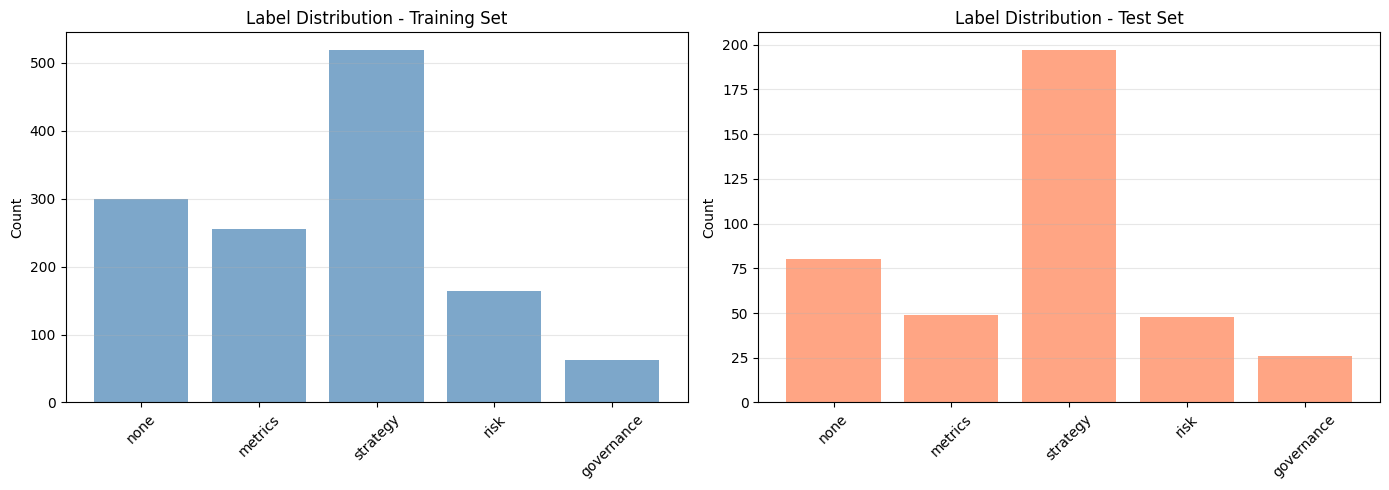

In [6]:
# Analyse label distribution
print("LABEL DISTRIBUTION")

train_labels = [ex['label'] for ex in dataset['train']]
test_labels = [ex['label'] for ex in dataset['test']]

# Count frequencies
train_counts = [train_labels.count(i) for i in range(NUM_LABELS)]
test_counts = [test_labels.count(i) for i in range(NUM_LABELS)]

# Create distribution table
dist_df = pd.DataFrame({
    'Label': LABEL_NAMES,
    'Train Count': train_counts,
    'Train %': [c/len(train_labels)*100 for c in train_counts],
    'Test Count': test_counts,
    'Test %': [c/len(test_labels)*100 for c in test_counts]
})

print("\n" + dist_df.to_string(index=False))

# Visualise
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(LABEL_NAMES, train_counts, alpha=0.7, color='steelblue')
axes[0].set_ylabel('Count')
axes[0].set_title('Label Distribution - Training Set')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(LABEL_NAMES, test_counts, alpha=0.7, color='coral')
axes[1].set_ylabel('Count')
axes[1].set_title('Label Distribution - Test Set')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Note: Severe class imbalance here - should be in their reflections piece!

### Show some example texts

In [7]:
# Get one example per class
examples_shown = 0
for label_idx in range(NUM_LABELS):
    for ex in dataset['train']:
        if ex['label'] == label_idx:
            print(f"\n{'='*80}")
            print(f"Example {examples_shown + 1}: {LABEL_NAMES[label_idx].upper()}")
            print(f"{'='*80}")
            print(f"Text: {ex['text'][:400]}...")
            
            examples_shown += 1
            break
    
    if examples_shown >= 6: 
        break


Example 1: NONE
Text: A material portion of this network is still relatively immature and there are risks that may develop over time. For example, it is possible that branches may not be able to sustain the level of revenue or profitability that they currently achieve (or that it is forecasted that they will achieve)....

Example 2: METRICS
Text: − Scope 3: Optional scope that includes indirect emissions associated with the goods and services supply chain produced outside the organization. Included are emissions from the transport of products from our logistics centres to stores (downstream) performed by external logistics operators (air, land and sea transport) as well as the emissions associated with electricity consumption in franchise ...

Example 3: STRATEGY
Text: The Group is not aware of any noise pollution that could negatively impact the environment, nor is it aware of any impact on biodiversity. With regards to land use, the Group is only a commercial user, and the Group is 

### Test-train-val split

In [8]:
# Split train into train/val (85/15 split, stratified)
train_val_split = dataset['train'].train_test_split(
    test_size=0.15, 
    seed=SEED, 
    stratify_by_column='label'
)

train_dataset = train_val_split['train']
val_dataset = train_val_split['test']
test_dataset = dataset['test']

print(f"\nSplits created:")
print(f"  Train:      {len(train_dataset):4d} samples ({len(train_dataset)/len(dataset['train'])*100:.1f}%)")
print(f"  Validation: {len(val_dataset):4d} samples ({len(val_dataset)/len(dataset['train'])*100:.1f}%)")
print(f"  Test:       {len(test_dataset):4d} samples")

# Check average text length
train_texts = [ex['text'] for ex in train_dataset]
avg_length = np.mean([len(text.split()) for text in train_texts])
print(f"\n  Average text length: {avg_length:.1f} tokens")


Splits created:
  Train:      1105 samples (85.0%)
  Validation:  195 samples (15.0%)
  Test:        400 samples

  Average text length: 72.7 tokens


---
# Task 2: Zero-Shot Evaluation (15 points)

Test the model without training using different prompt strategies.

In [9]:
# Load tokenizer and generator
print(f"\nLoading model: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

generator = pipeline(
    "text-generation",
    model=MODEL_NAME,
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else -1,
    max_new_tokens=20,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)



Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0...


Device set to use cuda
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Define a programmatic prompting template

In [10]:
# Define prompt templates

PROMPTS = {
    'direct': """Text: {text}

Which TCFD category? (governance/strategy/risk/metrics/none)
Answer:""",
    
    'instructional': """Classify this corporate climate disclosure into TCFD categories.

Categories: governance, strategy, risk management, metrics & targets, none

Text: {text}

Category:""",
    
    'definitions': """TCFD Categories:
- governance: board/management oversight
- strategy: business implications of climate change
- risk: climate risk management processes
- metrics: emissions data and targets
- none: not TCFD-related

Text: {text}

Category:""",
    
    'structured': """Task: Classify corporate disclosure into TCFD framework

TEXT:
{text}

TCFD CATEGORY (choose one):
Options: governance, strategy, risk, metrics, none

Answer:""",

    'detailed_definitions': """Identify the TCFD category for this disclosure.

DEFINITIONS:
- Governance: Organization's governance around climate-related risks and opportunities (board oversight, management's role, committee structure)
- Strategy: Actual and potential impacts of climate-related risks/opportunities on business, strategy, and financial planning
- Risk Management: Processes for identifying, assessing, and managing climate-related risks
- Metrics & Targets: Metrics and targets used to assess and manage relevant climate-related risks/opportunities (emissions data, reduction targets, Scope 1/2/3)
- None: Not related to TCFD framework

Text: {text}

Category:""",

    'keyword_guided': """Classify this disclosure using these indicators:

Governance: "board", "oversight", "management role", "committee", "responsibility"
Strategy: "business impact", "strategic", "resilience", "scenario", "opportunities"
Risk: "identify risk", "assess risk", "risk process", "risk management"
Metrics: "emissions", "GHG", "Scope 1/2/3", "targets", "reduction", "carbon"

Text: {text}

Category:""",

    'question_format': """Q: Which TCFD pillar does this corporate disclosure primarily address?

A) Governance (board/management oversight of climate issues)
B) Strategy (business implications of climate change)
C) Risk Management (processes for managing climate risks)
D) Metrics & Targets (emissions data and reduction goals)
E) None (not TCFD-related)

Text: {text}

Answer:""",

    'step_by_step': """Classify this text step-by-step:

Text: {text}

Step 1: Is it about board/management oversight? → governance
Step 2: Is it about business strategy impact? → strategy
Step 3: Is it about risk assessment processes? → risk
Step 4: Does it contain emissions data/targets? → metrics
Otherwise → none

Category:""",

    'contextual': """The TCFD (Task Force on Climate-related Financial Disclosures) framework has four pillars: Governance, Strategy, Risk Management, and Metrics & Targets.

Classify this corporate disclosure:

{text}

Which TCFD pillar does this belong to?
Answer:""",

    'explicit_instructions': """Read the text and choose the SINGLE most appropriate TCFD category.

Text: {text}

Select ONE:
- governance (if discussing board oversight, management roles, or governance structures)
- strategy (if discussing business implications, strategic planning, or resilience)
- risk (if discussing risk identification, assessment, or management processes)
- metrics (if containing emissions data, targets, or quantitative climate metrics)
- none (if not clearly fitting any TCFD pillar)

Selected category:"""
}

print(f"\n✓ Created {len(PROMPTS)} comprehensive prompt templates")
print("\nPrompt strategies tested:")
for i, name in enumerate(PROMPTS.keys(), 1):
    print(f"  {i:2d}. {name}")


✓ Created 10 comprehensive prompt templates

Prompt strategies tested:
   1. direct
   2. instructional
   3. definitions
   4. structured
   5. detailed_definitions
   6. keyword_guided
   7. question_format
   8. step_by_step
   9. contextual
  10. explicit_instructions


Need a parsing fn to assign class based on model's generative output

In [11]:
# Parsing function
def parse_output(generated_text):
    """
    Parse model output to extract TCFD category prediction.
    Returns: integer 0-4 for label index
    Order: ['governance', 'risk', 'strategy', 'metrics', 'none']
    """
    text_lower = generated_text.lower()
    
    # Extract just the answer part (first 40 chars)
    answer = text_lower[:40]
    
    # Check for letter-based answers first (A/B/C/D/E)
    if answer.strip().startswith('a)') or answer.strip().startswith('a.'):
        return 0  # governance
    if answer.strip().startswith('b)') or answer.strip().startswith('b.'):
        return 2  # strategy
    if answer.strip().startswith('c)') or answer.strip().startswith('c.'):
        return 1  # risk
    if answer.strip().startswith('d)') or answer.strip().startswith('d.'):
        return 3  # metrics
    if answer.strip().startswith('e)') or answer.strip().startswith('e.'):
        return 4  # none
    
    # Priority-based keyword matching
    # 1. Governance (most specific)
    if 'governance' in answer:
        return 0
    
    # 2. Metrics (check before "risk" to avoid confusion)
    if any(kw in answer for kw in ['metric', 'target', 'emission', 'scope']):
        return 3
    
    # 3. Risk (check "risk" appears and it's not just "strategic risk")
    if 'risk' in answer:
        # Make sure it's not "strategic risk" or "business risk"
        if 'strategy' not in answer[:25] and 'strategic' not in answer[:25]:
            return 1
    
    # 4. Strategy (very common)
    if 'strategy' in answer or 'strategic' in answer:
        return 2
    
    # 5. None
    if 'none' in answer or 'not' in answer:
        return 4
    
    # Default to 'strategy' (most common class)
    return 2

In [12]:
# Sample test data 
test_sample = test_dataset.shuffle(seed=SEED).select(range(min(EVAL_SAMPLES, len(test_dataset))))
print(f"\nTest samples: {len(test_sample)} examples")


Test samples: 100 examples


In [13]:
# Evaluate zero-shot with each prompt
zero_shot_results = {}

for prompt_name, prompt_template in PROMPTS.items():
    print(f"\n--- Evaluating '{prompt_name}' prompt ---")
    
    predictions = []
    true_labels = []
    
    for i, example in enumerate(test_sample):
        if (i + 1) % 20 == 0:
            print(f"  Processing {i+1}/{len(test_sample)}...", end='\r')
        
        # Create prompt (truncate text to fit prompt)
        text = example['text'][:350]
        prompt = prompt_template.format(text=text)
        
        try:
            output = generator(prompt, max_new_tokens=20, truncation=True)
            response = output[0]['generated_text'][len(prompt):].strip()
            pred = parse_output(response)
        except Exception as e:
            # If generation fails, predict most common class
            pred = 2  # strategy
        
        predictions.append(pred)
        true_labels.append(example['label'])
    
    print(f"  Processing {len(test_sample)}/{len(test_sample)}... Done!")
    
    # Calculate metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    accuracy = accuracy_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(true_labels, predictions, average='weighted', zero_division=0)
    
    # Store results with predictions
    zero_shot_results[prompt_name] = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'predictions': predictions,
        'true_labels': true_labels
    }
    
    print(f"  Accuracy:      {accuracy:.3f}")
    print(f"  F1 (macro):    {f1_macro:.3f}")
    print(f"  F1 (weighted): {f1_weighted:.3f}")

# Clean up generator
clear_memory()


--- Evaluating 'direct' prompt ---


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  Processing 100/100... Done!
  Accuracy:      0.170
  F1 (macro):    0.059
  F1 (weighted): 0.050

--- Evaluating 'instructional' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.170
  F1 (macro):    0.058
  F1 (weighted): 0.049

--- Evaluating 'definitions' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.160
  F1 (macro):    0.056
  F1 (weighted): 0.048

--- Evaluating 'structured' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.170
  F1 (macro):    0.059
  F1 (weighted): 0.050

--- Evaluating 'detailed_definitions' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.170
  F1 (macro):    0.065
  F1 (weighted): 0.067

--- Evaluating 'keyword_guided' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.280
  F1 (macro):    0.159
  F1 (weighted): 0.252

--- Evaluating 'question_format' prompt ---
  Processing 100/100... Done!
  Accuracy:      0.160
  F1 (macro):    0.086
  F1 (weighted): 0.065

--- Evaluating 'step_by_step' prompt ---
  


                       Accuracy  F1 Macro  F1 Weighted
direct                     0.17     0.059        0.050
instructional              0.17     0.058        0.049
definitions                0.16     0.056        0.048
structured                 0.17     0.059        0.050
detailed_definitions       0.17     0.065        0.067
keyword_guided             0.28     0.159        0.252
question_format            0.16     0.086        0.065
step_by_step               0.16     0.071        0.091
contextual                 0.17     0.065        0.068
explicit_instructions      0.17     0.059        0.050

Best prompt: 'keyword_guided'
   F1 (macro): 0.159

Performance range:
  F1 Macro:  0.056 - 0.159 (Δ = 0.103)
  Accuracy:  0.160 - 0.280 (Δ = 0.120)


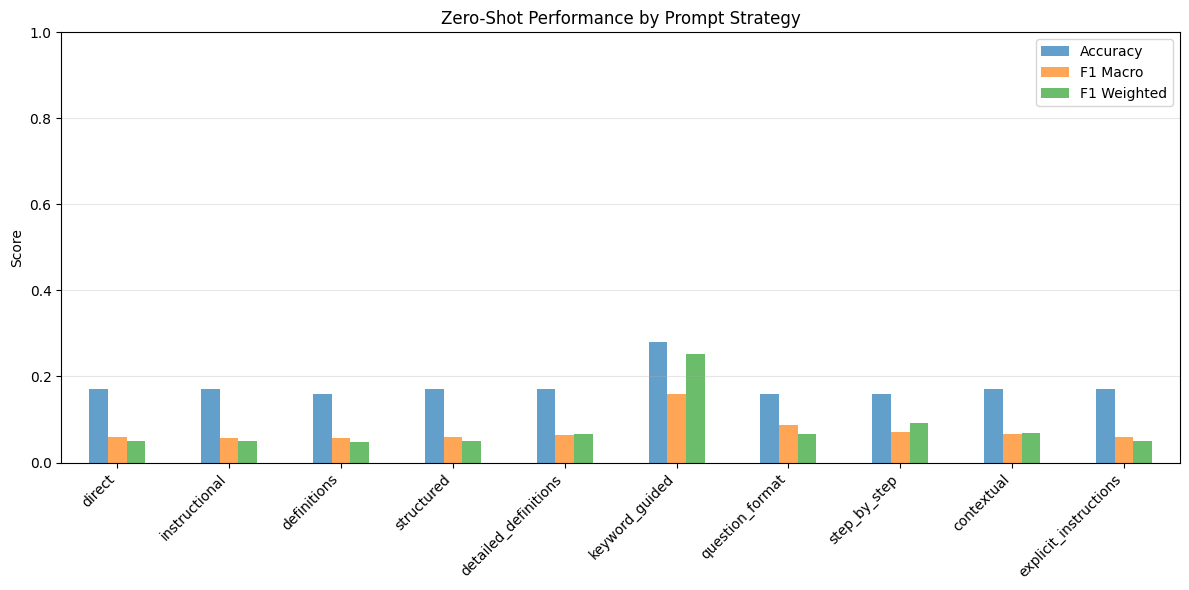

In [14]:
# Compare prompt performance
results_df = pd.DataFrame({
    name: {
        'Accuracy': res['accuracy'],
        'F1 Macro': res['f1_macro'],
        'F1 Weighted': res['f1_weighted']
    }
    for name, res in zero_shot_results.items()
}).T

print("\n" + results_df.round(3).to_string())

# Find best prompt
best_prompt = results_df['F1 Macro'].idxmax()
best_f1 = results_df.loc[best_prompt, 'F1 Macro']

print(f"\nBest prompt: '{best_prompt}'")
print(f"   F1 (macro): {best_f1:.3f}")

# Performance range
print(f"\nPerformance range:")
print(f"  F1 Macro:  {results_df['F1 Macro'].min():.3f} - {results_df['F1 Macro'].max():.3f} (Δ = {results_df['F1 Macro'].max() - results_df['F1 Macro'].min():.3f})")
print(f"  Accuracy:  {results_df['Accuracy'].min():.3f} - {results_df['Accuracy'].max():.3f} (Δ = {results_df['Accuracy'].max() - results_df['Accuracy'].min():.3f})")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
results_df[['Accuracy', 'F1 Macro', 'F1 Weighted']].plot(
    kind='bar', 
    ax=ax, 
    alpha=0.7
)
ax.set_ylabel('Score')
ax.set_title('Zero-Shot Performance by Prompt Strategy')
ax.set_ylim([0, 1])
ax.legend(['Accuracy', 'F1 Macro', 'F1 Weighted'])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Reflection: Zero-Shot Prompt Engineering

{... write their reflections here...}

---
# Task 3: Few-Shot Evaluation (10 points)

Test if providing examples in the prompt improves performance.

In [15]:
# Reload generator (was deleted earlier)
generator = pipeline(
    "text-generation",
    model=MODEL_NAME,
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else -1,
    max_new_tokens=20,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)

Device set to use cuda


### Select few-shot examples (one per class)

Searching for one example per TCFD category...

In [16]:
few_shot_examples = []

for label_idx in range(NUM_LABELS):
    for ex in train_dataset:
        if ex['label'] == label_idx:
            text_short = ex['text'][:1000]  # Keep short
            label_name = LABEL_NAMES[label_idx]
            
            few_shot_examples.append({
                'text': text_short,
                'label': label_name,
                'label_idx': label_idx
            })
            break

print(f"\nSelected {len(few_shot_examples)} examples:")
for i, ex in enumerate(few_shot_examples, 1):
    print(f"\n  {i}. Label: {ex['label'].upper()}")
    print(f"     {ex['text']}...")


Selected 5 examples:

  1. Label: NONE
     Through these initiatives, Konica Minolta is aiming to achieve the business targets of more than ¥75 billion in operating profit, ¥50 billion in profit attributable to owners of the company, and ROE of 9.5% by fiscal 2019, the final year of the Medium Term Business Plan. Beyond this, we are looking to achieve a medium-term target of more than ¥100 billion in operating profit and more than ¥70 billion in profit attributable to owners of the company by fiscal 2021....

  2. Label: METRICS
     We have developed two new portfolio metrics to provide greater transparency to the alignment of our power generation and commercial building portfolios with climate scenarios. These two sectors were chosen because electricity generation is responsible for around a third of Australia's national emissions with the non-residential buildings sector among the largest final end users of electricity. Supporting our customers' efforts to decarbonise the electric

### Create few-shot prompt 
here simply adding examples to best zero-shot

In [17]:
# Create few-shot prompt templates
def create_few_shot_prompt(test_text):
    """
    Add examples to the best zero-shot prompt.
    Simple approach: prepend examples before the task.
    """
    
    # Get the base instruction from best zero-shot prompt
    base_prompt = PROMPTS[best_prompt]
    
    # Split to get instruction part and format template
    if 'Text:' in base_prompt:
        instruction = base_prompt.split('Text:')[0].strip()
        suffix = '\n\nText: {text}\n\nCategory:'
    else:
        instruction = "Classify corporate climate disclosure into TCFD categories."
        suffix = '\n\nText: {text}\n\nCategory:'
    
    # Build few-shot prompt
    prompt = instruction + "\n\nExamples:\n\n"
    
    for i, ex in enumerate(few_shot_examples, 1):
        prompt += f"{i}. Text: {ex['text']}...\n"
        prompt += f"   Category: {ex['label']}\n\n"
    
    # Add test case
    prompt += f"Now classify:\nText: {test_text[:120]}...\n\nCategory:"
    
    return prompt

# Show example prompt
example_prompt = create_few_shot_prompt(test_dataset[0]['text'])

print("EXAMPLE FEW-SHOT PROMPT:")
print(f"Length: {len(example_prompt)} chars (~{len(example_prompt)//4} tokens)")
print(f"\n\n{example_prompt}...")


EXAMPLE FEW-SHOT PROMPT:
Length: 2878 chars (~719 tokens)


Classify this disclosure using these indicators:

Governance: "board", "oversight", "management role", "committee", "responsibility"
Strategy: "business impact", "strategic", "resilience", "scenario", "opportunities"
Risk: "identify risk", "assess risk", "risk process", "risk management"
Metrics: "emissions", "GHG", "Scope 1/2/3", "targets", "reduction", "carbon"

Examples:

1. Text: Through these initiatives, Konica Minolta is aiming to achieve the business targets of more than ¥75 billion in operating profit, ¥50 billion in profit attributable to owners of the company, and ROE of 9.5% by fiscal 2019, the final year of the Medium Term Business Plan. Beyond this, we are looking to achieve a medium-term target of more than ¥100 billion in operating profit and more than ¥70 billion in profit attributable to owners of the company by fiscal 2021....
   Category: none

2. Text: We have developed two new portfolio metrics to provide

In [18]:
# Evaluate

few_shot_predictions = []
few_shot_true_labels = []

for i, example in enumerate(test_sample):
    if (i + 1) % 20 == 0:
        print(f"  Processing {i+1}/{len(test_sample)}...", end='\r')
    
    prompt = create_few_shot_prompt(example['text'])
    
    try:
        output = generator(prompt, max_new_tokens=20, truncation=True)
        response = output[0]['generated_text'][len(prompt):].strip()
        pred = parse_output(response)
    except:
        pred = 2  # Default to strategy
    
    few_shot_predictions.append(pred)
    few_shot_true_labels.append(example['label'])

print(f"  Processing {len(test_sample)}/{len(test_sample)}... Done!")

# Calculate metrics
few_shot_predictions = np.array(few_shot_predictions)
few_shot_true_labels = np.array(few_shot_true_labels)

few_shot_accuracy = accuracy_score(few_shot_true_labels, few_shot_predictions)
few_shot_f1_macro = f1_score(few_shot_true_labels, few_shot_predictions, average='macro', zero_division=0)
few_shot_f1_weighted = f1_score(few_shot_true_labels, few_shot_predictions, average='weighted', zero_division=0)
few_shot_f1_per_class = f1_score(few_shot_true_labels, few_shot_predictions, average=None, zero_division=0)

print(f"\nFew-Shot Results:")
print(f"  Accuracy:      {few_shot_accuracy:.3f}")
print(f"  F1 (macro):    {few_shot_f1_macro:.3f}")
print(f"  F1 (weighted): {few_shot_f1_weighted:.3f}")
print("\n")

# Clean up
clear_memory()

  Processing 100/100... Done!

Few-Shot Results:
  Accuracy:      0.140
  F1 (macro):    0.081
  F1 (weighted): 0.152


GPU Memory cleared: 0.01GB allocated, 0.02GB reserved


### Comparison (zero vs few shot)


             Zero-Shot (keyword_guided)  Few-Shot  Difference  % Change
Accuracy                          0.280     0.140      -0.140     -50.0
F1 Macro                          0.159     0.081      -0.078     -49.0
F1 Weighted                       0.252     0.152      -0.100     -39.5

PER-CLASS F1 COMPARISON

Per-class F1 scores:
  none        : Zero=0.290, Few=0.000, Δ=-0.290
  metrics     : Zero=0.000, Few=0.000, Δ=+0.000
  strategy    : Zero=0.400, Few=0.308, Δ=-0.092
  risk        : Zero=0.105, Few=0.000, Δ=-0.105
  governance  : Zero=0.000, Few=0.098, Δ=+0.098


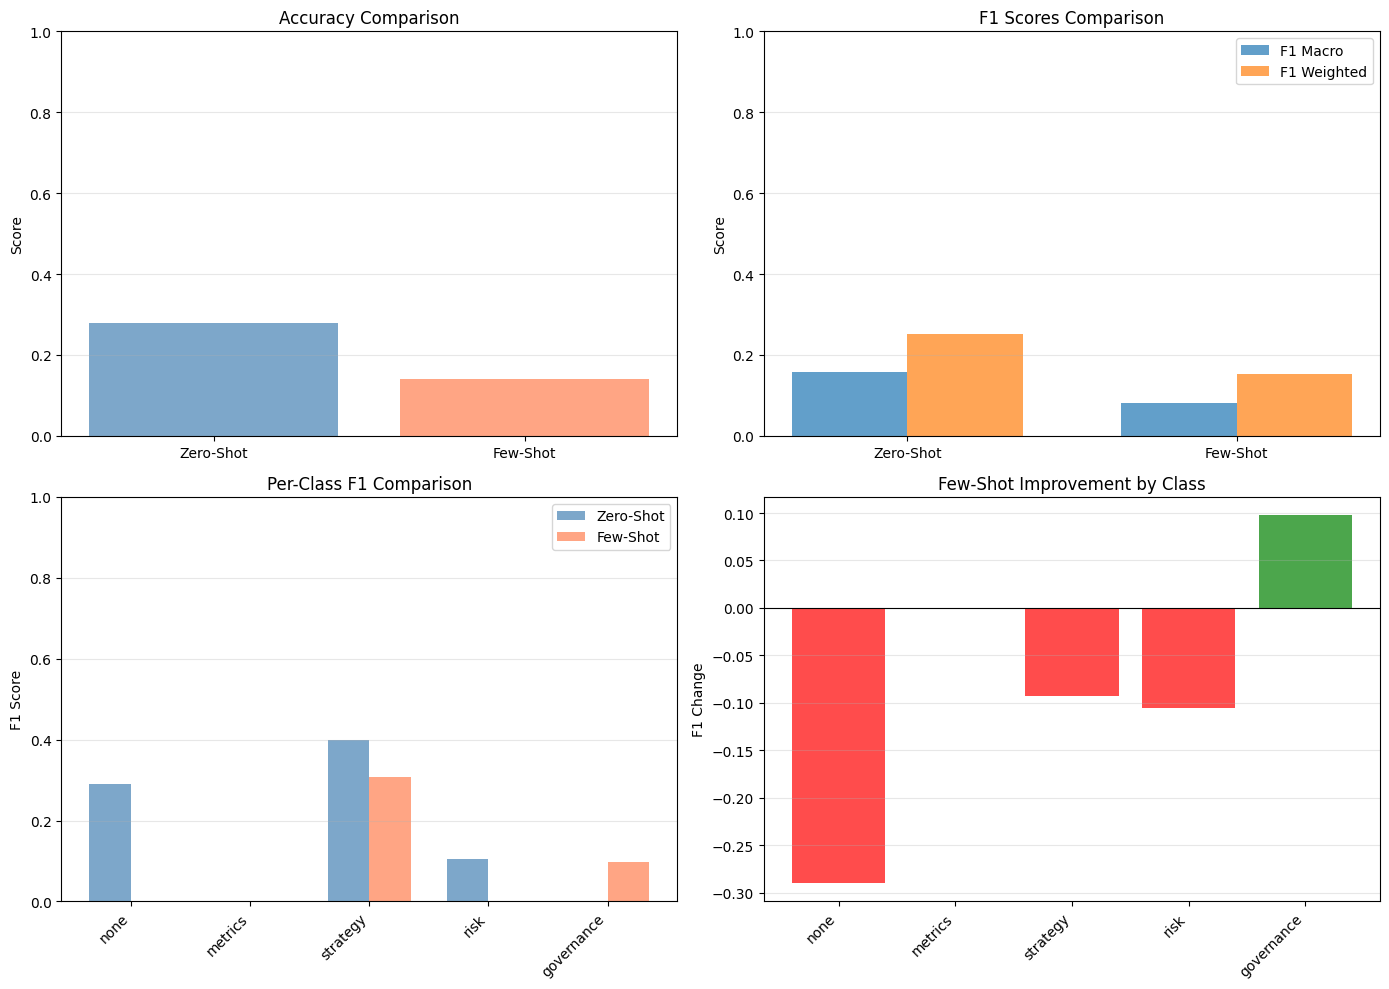

In [19]:
comparison = pd.DataFrame({
    f'Zero-Shot ({best_prompt})': [
        zero_shot_results[best_prompt]['accuracy'],
        zero_shot_results[best_prompt]['f1_macro'],
        zero_shot_results[best_prompt]['f1_weighted']
    ],
    'Few-Shot': [
        few_shot_accuracy,
        few_shot_f1_macro,
        few_shot_f1_weighted
    ]
}, index=['Accuracy', 'F1 Macro', 'F1 Weighted'])

comparison['Difference'] = comparison['Few-Shot'] - comparison[f'Zero-Shot ({best_prompt})']
comparison['% Change'] = (comparison['Difference'] / comparison[f'Zero-Shot ({best_prompt})'] * 100).round(1)

print("\n" + comparison.round(3).to_string())

# Per-class comparison
print("\n" + "="*80)
print("PER-CLASS F1 COMPARISON")
print("="*80)

zero_shot_f1_per_class = f1_score(
    zero_shot_results[best_prompt]['true_labels'], 
    zero_shot_results[best_prompt]['predictions'], 
    average=None, 
    zero_division=0
)

print("\nPer-class F1 scores:")
for i, label_name in enumerate(LABEL_NAMES):
    zero_f1 = zero_shot_f1_per_class[i]
    few_f1 = few_shot_f1_per_class[i]
    diff = few_f1 - zero_f1
    print(f"  {label_name:12s}: Zero={zero_f1:.3f}, Few={few_f1:.3f}, Δ={diff:+.3f}")

# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Overall metrics
x = ['Zero-Shot', 'Few-Shot']
axes[0, 0].bar(x, [zero_shot_results[best_prompt]['accuracy'], few_shot_accuracy],
               alpha=0.7, color=['steelblue', 'coral'])
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. F1 scores
x_pos = np.arange(2)
width = 0.35
axes[0, 1].bar(x_pos - width/2, 
               [zero_shot_results[best_prompt]['f1_macro'], few_shot_f1_macro],
               width, label='F1 Macro', alpha=0.7)
axes[0, 1].bar(x_pos + width/2,
               [zero_shot_results[best_prompt]['f1_weighted'], few_shot_f1_weighted],
               width, label='F1 Weighted', alpha=0.7)
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('F1 Scores Comparison')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(['Zero-Shot', 'Few-Shot'])
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Per-class F1
x = np.arange(len(LABEL_NAMES))
width = 0.35
axes[1, 0].bar(x - width/2, zero_shot_f1_per_class, width, 
               label='Zero-Shot', alpha=0.7, color='steelblue')
axes[1, 0].bar(x + width/2, few_shot_f1_per_class, width,
               label='Few-Shot', alpha=0.7, color='coral')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Per-Class F1 Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(LABEL_NAMES, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Improvement by class
improvements = few_shot_f1_per_class - zero_shot_f1_per_class
colors = ['green' if imp > 0.02 else 'red' if imp < -0.02 else 'gray' for imp in improvements]
axes[1, 1].bar(LABEL_NAMES, improvements, alpha=0.7, color=colors)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].set_ylabel('F1 Change')
axes[1, 1].set_title('Few-Shot Improvement by Class')
axes[1, 1].tick_params(axis='x', rotation=45)
plt.setp(axes[1, 1].get_xticklabels(), ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Reflection: Few-Shot Learning 
{write their reflections here...}

---
# Task 4: LoRA Fine-Tuning (15 points)

LoRA (Low-Rank Adaptation) is a parameter-efficient fine-tuning method that keeps the original pretrained model frozen and injects small trainable rank-decomposed matrices into its weight layers. Instead of updating all model parameters, it learns low-rank updates that approximate the weight changes needed for a new task. This drastically reduces memory and compute requirements while maintaining performance close to full fine-tuning.

**TODO**:
1. Prepare tokenized datasets
2. Load model for classification
3. Apply LoRA configuration
4. Train for 10 epochs
5. Plot learning curves
6. Evaluate on test set

In [20]:
# Prepare tokenized datasets
print("\nPreparing datasets for fine-tuning...")

def tokenize_function(examples):
    """Tokenize texts and prepare labels."""
    tokenized = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512
    )
    tokenized['labels'] = examples['label']
    return tokenized

# Tokenize all splits
train_tokenized = train_dataset.map(
    tokenize_function, 
    batched=True, 
    remove_columns=train_dataset.column_names
)
val_tokenized = val_dataset.map(
    tokenize_function, 
    batched=True, 
    remove_columns=val_dataset.column_names
)
test_tokenized = test_dataset.map(
    tokenize_function, 
    batched=True, 
    remove_columns=test_dataset.column_names
)

train_tokenized.set_format('torch')
val_tokenized.set_format('torch')
test_tokenized.set_format('torch')

print(f"✓ Tokenization complete")
print(f"  Train: {len(train_tokenized)} samples")
print(f"  Val:   {len(val_tokenized)} samples")
print(f"  Test:  {len(test_tokenized)} samples")



Preparing datasets for fine-tuning...
✓ Tokenization complete
  Train: 1105 samples
  Val:   195 samples
  Test:  400 samples


In [21]:
# Load model for classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="single_label_classification",
    id2label={i: name for i, name in enumerate(LABEL_NAMES)},
    label2id={name: i for i, name in enumerate(LABEL_NAMES)}
)
model.config.pad_token_id = tokenizer.pad_token_id

print(f"\{MODEL_NAME} loaded with {model.num_parameters():,} parameters")
print(f"  Classification head: {NUM_LABELS} classes")


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


\TinyLlama/TinyLlama-1.1B-Chat-v1.0 loaded with 1,034,522,624 parameters
  Classification head: 5 classes


In [22]:
# Apply LoRA
lora_config = LoraConfig(
    r=8,                          # Rank (complexity of adaptation)
    lora_alpha=32,                # Scaling factor
    target_modules=TARGET_MODULES, # Which layers to adapt
    lora_dropout=0.1,             # Dropout for regularization
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)

print(f"\n✓ LoRA applied")
model.print_trainable_parameters()


✓ LoRA applied
trainable params: 2,263,040 || all params: 1,036,785,664 || trainable%: 0.2183


In [23]:
# Training configuration
training_args = TrainingArguments(
    output_dir="./tcfd_tinyllama_lora",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,  # To simulate larger batch size
    learning_rate=1e-4,
    weight_decay=0.01,
    warmup_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=25,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=SEED
)

print(f"\nTraining parameters:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Warmup steps: {training_args.warmup_steps}")
print(f"  Evaluation: Every epoch")
print(f"  FP16: {training_args.fp16}")



Training parameters:
  Epochs: 10
  Batch size: 2
  Learning rate: 0.0001
  Warmup steps: 100
  Evaluation: Every epoch
  FP16: True


In [24]:
# Define metrics function
def compute_metrics(eval_pred):
    """Calculate evaluation metrics."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

In [25]:
# Create Traine
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

### Training

In [ ]:
# Train model
print("\n" + "="*80)
print(f"TRAINING FOR {NUM_EPOCHS} EPOCHS")
print("="*80)

train_result = trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"  Total time: {train_result.metrics['train_runtime']:.1f}s ({train_result.metrics['train_runtime']/60:.1f} min)")
print(f"  Training loss: {train_result.metrics['train_loss']:.4f}")
print(f"  Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")



TRAINING FOR 10 EPOCHS


Epoch,Training Loss,Validation Loss


In [ ]:
# Plot learning curves

log_history = trainer.state.log_history

# Extract training and validation metrics
train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

if train_logs and eval_logs:
    # Training loss
    train_steps = [log['step'] for log in train_logs]
    train_loss = [log['loss'] for log in train_logs]
    
    # Validation metrics
    eval_epochs = [log['epoch'] for log in eval_logs]
    eval_loss = [log['eval_loss'] for log in eval_logs]
    eval_f1 = [log['eval_f1_macro'] for log in eval_logs]
    eval_acc = [log['eval_accuracy'] for log in eval_logs]
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    axes[0].plot(train_steps, train_loss, label='Training Loss', alpha=0.7)
    # Map eval loss to steps (approximate)
    eval_steps = [step for step in train_steps if any(abs(step/len(train_steps)*NUM_EPOCHS - e) < 0.1 for e in eval_epochs)]
    if len(eval_steps) == len(eval_loss):
        axes[0].plot(eval_steps, eval_loss, label='Validation Loss', marker='o', markersize=6)
    axes[0].set_xlabel('Training Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Progress: Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Validation metrics
    axes[1].plot(eval_epochs, eval_acc, marker='o', label='Accuracy', markersize=8, linewidth=2)
    axes[1].plot(eval_epochs, eval_f1, marker='s', label='F1 (macro)', markersize=8, linewidth=2)
    axes[1].axhline(y=zero_shot_results[best_prompt]['f1_macro'], 
                    color='red', linestyle='--', alpha=0.5, label='Zero-shot F1')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Validation Performance')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nLearning curves show {'improvement' if eval_f1[-1] > eval_f1[0] else 'potential overfitting'}")


### Eval on test set

In [ ]:
# Evaluate on test set
test_results = trainer.evaluate(test_tokenized)

print(f"\nTest Set Performance:")
print(f"  Accuracy:      {test_results['eval_accuracy']:.4f}")
print(f"  F1 (macro):    {test_results['eval_f1_macro']:.4f}")
print(f"  F1 (weighted): {test_results['eval_f1_weighted']:.4f}")

# Get predictions for detailed analysis
predictions_output = trainer.predict(test_tokenized)
predictions = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

# Task 5: Comprehensive Evaluation and Analysis (10 points)

Analyse model performance, identify error patterns, and reflect on findings.

Here's a possible set of programmatic solutions students could consider for write up.

### Per class performance

In [ ]:
# Per-class performance
print("\n" + "="*80)
print("PER-CLASS PERFORMANCE")
print("="*80)

print("\n" + classification_report(
    true_labels,
    predictions,
    target_names=LABEL_NAMES,
    digits=3
))

### Confusion Matrix

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix: Fine-Tuned Model')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Identify error cases

In [ ]:
# Find misclassified examples
errors = []
for i, (true_label, pred_label) in enumerate(zip(true_labels, predictions)):
    if true_label != pred_label:
        errors.append({
            'index': i,
            'text': test_dataset[i]['text'],
            'true_label': LABEL_NAMES[true_label],
            'predicted_label': LABEL_NAMES[pred_label],
            'true_idx': true_label,
            'pred_idx': pred_label
        })

print(f"\nTotal errors: {len(errors)} / {len(test_dataset)} ({len(errors)/len(test_dataset)*100:.1f}%)")

# Show 10 error examples
print("\n" + "="*80)
print("ERROR EXAMPLES (showing first 10)")
print("="*80)

for i, error in enumerate(errors[:10], 1):
    print(f"\n{'='*80}")
    print(f"Error {i}:")
    print(f"{'='*80}")
    print(f"Text: {error['text'][:300]}...")
    print(f"\nTrue label:      {error['true_label']}")
    print(f"Predicted label: {error['predicted_label']}")
    print(f"\nPossible reason:")
    
    # Analyze error type
    if error['true_label'] == 'governance' or error['predicted_label'] == 'governance':
        print("  → Governance is rare class (6.5% of data) - model under-predicts it")
    elif error['true_label'] == 'strategy' or error['predicted_label'] == 'strategy':
        print("  → Strategy is majority class (49%) - model over-predicts it")
    elif 'risk' in [error['true_label'], error['predicted_label']] and 'strategy' in [error['true_label'], error['predicted_label']]:
        print("  → Risk vs. Strategy confusion - these categories overlap (risks affect strategy)")
    else:
        print("  → Ambiguous language or context-dependent classification")

In [ ]:
# Error taxonomy
# Categorize errors
error_categories = {
    'Rare class (governance/risk)': 0,
    'Strategy over-prediction': 0,
    'Risk-Strategy confusion': 0,
    'Metrics misclassification': 0,
    'Other': 0
}

for error in errors:
    true_label = error['true_label']
    pred_label = error['predicted_label']
    
    if true_label in ['governance', 'risk']:
        error_categories['Rare class (governance/risk)'] += 1
    elif pred_label == 'strategy' and true_label != 'strategy':
        error_categories['Strategy over-prediction'] += 1
    elif set([true_label, pred_label]) == set(['risk', 'strategy']):
        error_categories['Risk-Strategy confusion'] += 1
    elif 'metrics' in [true_label, pred_label]:
        error_categories['Metrics misclassification'] += 1
    else:
        error_categories['Other'] += 1

# Create taxonomy table
taxonomy_df = pd.DataFrame({
    'Error Category': list(error_categories.keys()),
    'Count': list(error_categories.values()),
    'Percentage': [v/len(errors)*100 for v in error_categories.values()]
})

print("\n" + taxonomy_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(taxonomy_df['Error Category'], taxonomy_df['Count'], alpha=0.7, color='coral')
ax.set_ylabel('Error Count')
ax.set_title('Error Distribution by Category')
ax.tick_params(axis='x', rotation=45)
plt.xticks(ha='right')
plt.tight_layout()
plt.show()

## Final Comparison

In [ ]:
final_comparison = pd.DataFrame({
    'Approach': [
        'Zero-Shot (direct)',
        'Zero-Shot (best prompt)',
        'Few-Shot',
        'LoRA Fine-Tuned'
    ],
    'F1 Macro': [
        zero_shot_results['direct']['f1_macro'],
        zero_shot_results[best_prompt]['f1_macro'],
        few_shot_f1_macro,
        test_results['eval_f1_macro']
    ],
    'Accuracy': [
        zero_shot_results['direct']['accuracy'],
        zero_shot_results[best_prompt]['accuracy'],
        few_shot_accuracy,
        test_results['eval_accuracy']
    ]
})

print("\n" + final_comparison.round(3).to_string(index=False))

# Visualize progression
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(final_comparison))
width = 0.35

ax.bar(x - width/2, final_comparison['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x + width/2, final_comparison['F1 Macro'], width, label='F1 Macro', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Learning Progression: Zero-Shot → Few-Shot → Fine-Tuned')
ax.set_xticks(x)
ax.set_xticklabels(final_comparison['Approach'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOverall improvement: {test_results['eval_f1_macro'] - zero_shot_results['direct']['f1_macro']:.3f} F1")
print(f"   ({(test_results['eval_f1_macro'] / zero_shot_results['direct']['f1_macro'] - 1)*100:.1f}% relative improvement)")


### Comprehensive Reflection 

...a qualitiative write up.